In [6]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool

In [237]:
#Gets current price of a particular stock ticker
def get_current_price(symbol):
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return todays_data['Close'][0]


#Gets the data for a list of stocks from start to end date. Returns percent change and covariance Matrix
def getData(stocks, start, end):
    stockData = yf.download(stocks, start, end)['Close']
    returns = stockData.pct_change().dropna()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

#Calculates weight of stocks in a portfolio given no. of each stock
def calcWeights(stocks, stock_nos):
  stock_val = np.zeros(shape = (len(stocks)), dtype = np.float32)
  for ind, stock in enumerate(stocks):
    stock_val[ind]=(get_current_price(stock)*stock_nos[ind])
  total_val = np.sum(stock_val)
  return [stock/total_val for stock in stock_val], total_val

#Runs the actual Monte Carlo Simulation
def MonteCarlo(weights, meanReturns, total_val, covMatrix, T = 100, mc_sims = 400):
  meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns) #Nothing but the avg returns for each stock
  meanM = meanM.T
  portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0) #Here, we will add portfolio results for m simulations over T time periods
  portfolio_return_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
  #For loop running the actual sims
  for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights))) #Each stock is assumed a normal variable to daily returns are a random walk through normal distribution
    L = np.linalg.cholesky(covMatrix) #We use a Cholesky Decomposition to Generate our Multivariate Normal Distribution. 
    dailyReturns = meanM + np.inner(L, Z) 
    '''
    Daily returns are nothing but the Mean +- the Inner product of Separate Normal Distributions and the Cholesky Lower Triangle Matrix(L)
    Here, this inner product is what generates our Multivariate Normal Distribution.
    For the purposes of this Monte Carlo SIm, we assume portfolio returns to be a Multivariate Normal Distribution and each simulation is a random walk through the same.
    For more details, refer http://www.math.kent.edu/~reichel/courses/monte.carlo/alt4.7c.pdf
      '''
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*total_val #Multiplying by weights and initial portfolio value to get our returns
    portfolio_return_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*100

  return portfolio_sims, portfolio_return_sims

def VaR(returns, alpha=5):
  return np.percentile(returns, alpha)
    
def cVaR(returns, alpha=5):
  belowVaR = returns <= VaR(returns, alpha=alpha)
  return returns[belowVaR].mean()

In [162]:
meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T
s = mc_simulation(weights, meanReturns, total_val, covMatrix, T, meanM)
len(s)

365

In [207]:
no_stocks = int(input('Please enter the number of stocks: '))
stockList = []
stock_nos = []
for i in range(no_stocks):
  stock = input('Please Enter NSE Ticker of Stock {:d}: '.format(i+1))
  stockList.append(stock)
  no = int(input('Please Enter No. of shares of {:s} you own: '.format(stock)))
  stock_nos.append(no)
lookback_period = float(input('Please enter the lookback period you wish to use data from (yrs, can be a decimal): '))
mc_sims = int(input('Please enter the number of simulations you wish to run(try to keep under 100,000): '))
T = float(input('Please enter the number of yrs into the future you want to predict portfolio returns (yrs, can be decimal): '))
if len(stockList)==1:
  stockList.append('NIFTY')
  stock_nos.append(0)
stocks = [st + '.NS' for st in stockList]
lookback_period = int(lookback_period*365)
T = int(T*365)
if len(stockList)==1: #If only 1 stock, compares to NIFTY
  stocks.append('^NSEI') 
  stock_nos.append(0)

Please enter the number of stocks: 1
Please Enter NSE Ticker of Stock 1: ZOMATO
Please Enter No. of shares of ZOMATO you own: 2
Please enter the lookback period you wish to use data from (yrs, can be a decimal): 2
Please enter the number of simulations you wish to run(try to keep under 100,000): 122
Please enter the number of yrs into the future you want to predict portfolio returns (yrs, can be decimal): 1


In [196]:
stock_nos

[2]

In [251]:
stockList = ['NAVINFLUOR', 'ZOMATO']
stock_nos = [1, 2]
stocks = [st + '.NS' for st in stockList]
if len(stockList)==1: #If only 1 stock, compares to NIFTY
  stocks.append('^NSEI') 
  stock_nos.append(0)
lookback_period = 100 #Let's use historical data from 300 days
mc_sims = 10000 # number of simulations
T = 365 #Let's predict Portfolio Value 1 year from now
percent = True #Decides whether to print Portfolio Value or Percent Change

In [252]:
end = dt.date.today() #Sets today's date as end date
start = end - dt.timedelta(days = lookback_period)
returns, meanReturns, covMatrix = getData(stocks, start, end)
weights, total_val = calcWeights(stocks, stock_nos)
portfolio_vals, portfolio_percents = MonteCarlo(weights, meanReturns, total_val, covMatrix, T, mc_sims)
if(percent):
  results = portfolio_percents[-1, :]
else:
  results = portfolio_vals[-1, :]

[*********************100%***********************]  2 of 2 completed


Initial Portfolio Value: Rs. 3865


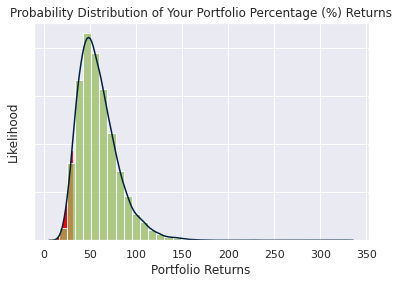

Most Probable Results: 55.01 %
Variance at Risk: 30.76 %
Conditional Variance at Risk: 26.71 %


In [253]:
#SNS Plot for our simulated returns
sns.set_style('darkgrid')
ax = sns.histplot(data=results, kde=False, stat='density', bins = 35, fill=True, color = '#97BC62FF')
sns.kdeplot(data=results, color='#00203FFF', ax=ax)
kde_x, kde_y = ax.lines[0].get_data()
x0 = VaR(results)
ax.fill_between(kde_x, kde_y, where=(kde_x<x0) , interpolate=True, color = 'red')
if(not percent):
  ax.set_title("Probability Distribution of Your Portfolio Returns")
else:
  ax.set_title("Probability Distribution of Your Portfolio Percentage (%) Returns")
ax.set(xlabel='Portfolio Returns', ylabel='Likelihood')
ax.set_yticklabels([])
print("Initial Portfolio Value: Rs. {:d}".format(int(total_val)))
plt.show()
if(not percent):
  print("25th Percentile Returns: {:.2f}".format(np.percentile(results, 25)))
  print("Average (50th Percentile) Returns: {:.2f}".format(np.percentile(results, 50)))
  print("75th Percentile Returns: {:.2f}".format(np.percentile(results, 75)))
  print("Variance at Risk: {:.2f}".format(VaR(results)))
  print("Conditional Variance at Risk: {:.2f}".format(cVaR(results)))
else:
  print("25th Percentile Returns: {:.2f} %".format(np.percentile(results, 25)))
  print("Average (50th Percentile) Returns: {:.2f} %".format(np.percentile(results, 50)))
  print("75th Percentile Returns: {:.2f} %".format(np.percentile(results, 75)))
  print("Variance at Risk: {:.2f} %".format(VaR(results)))
  print("Conditional Variance at Risk: {:.2f} %".format(cVaR(results)))

In [147]:
dict1 = {'Initial Portfolio Value': [total_val], '25th Percentile Returns':[np.percentile(results, 25)], 'Average Returns':[np.percentile(results, 50)],
         '75th Percentile Returns':[np.percentile(results, 75)], 'Variance at Risk':[VaR(results)], 'Conditional Variance at Risk':[cVaR(results)]}

In [148]:
pd.DataFrame(dict1)

,Initial Portfolio Value,25th Percentile Returns,Average Returns,75th Percentile Returns,Variance at Risk,Conditional Variance at Risk
0,94222.0,82214.84944,99181.9281,120479.51745,62640.870337,55944.148564


<function matplotlib.pyplot.show>

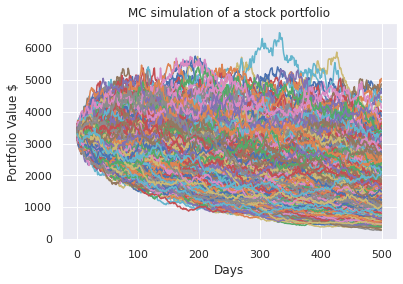

In [ ]:
plt.plot(ps)
plt.ylabel('Portfolio Value $')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show